Click within red rectangle. Bounds: Lat 27.009852 to 28.183670, Lng 86.271783 to 87.124751


Latitude:  27.1504
Longitude:   86.4334
Use Lat=27.150400, Lng=86.433400? (y/n):  y


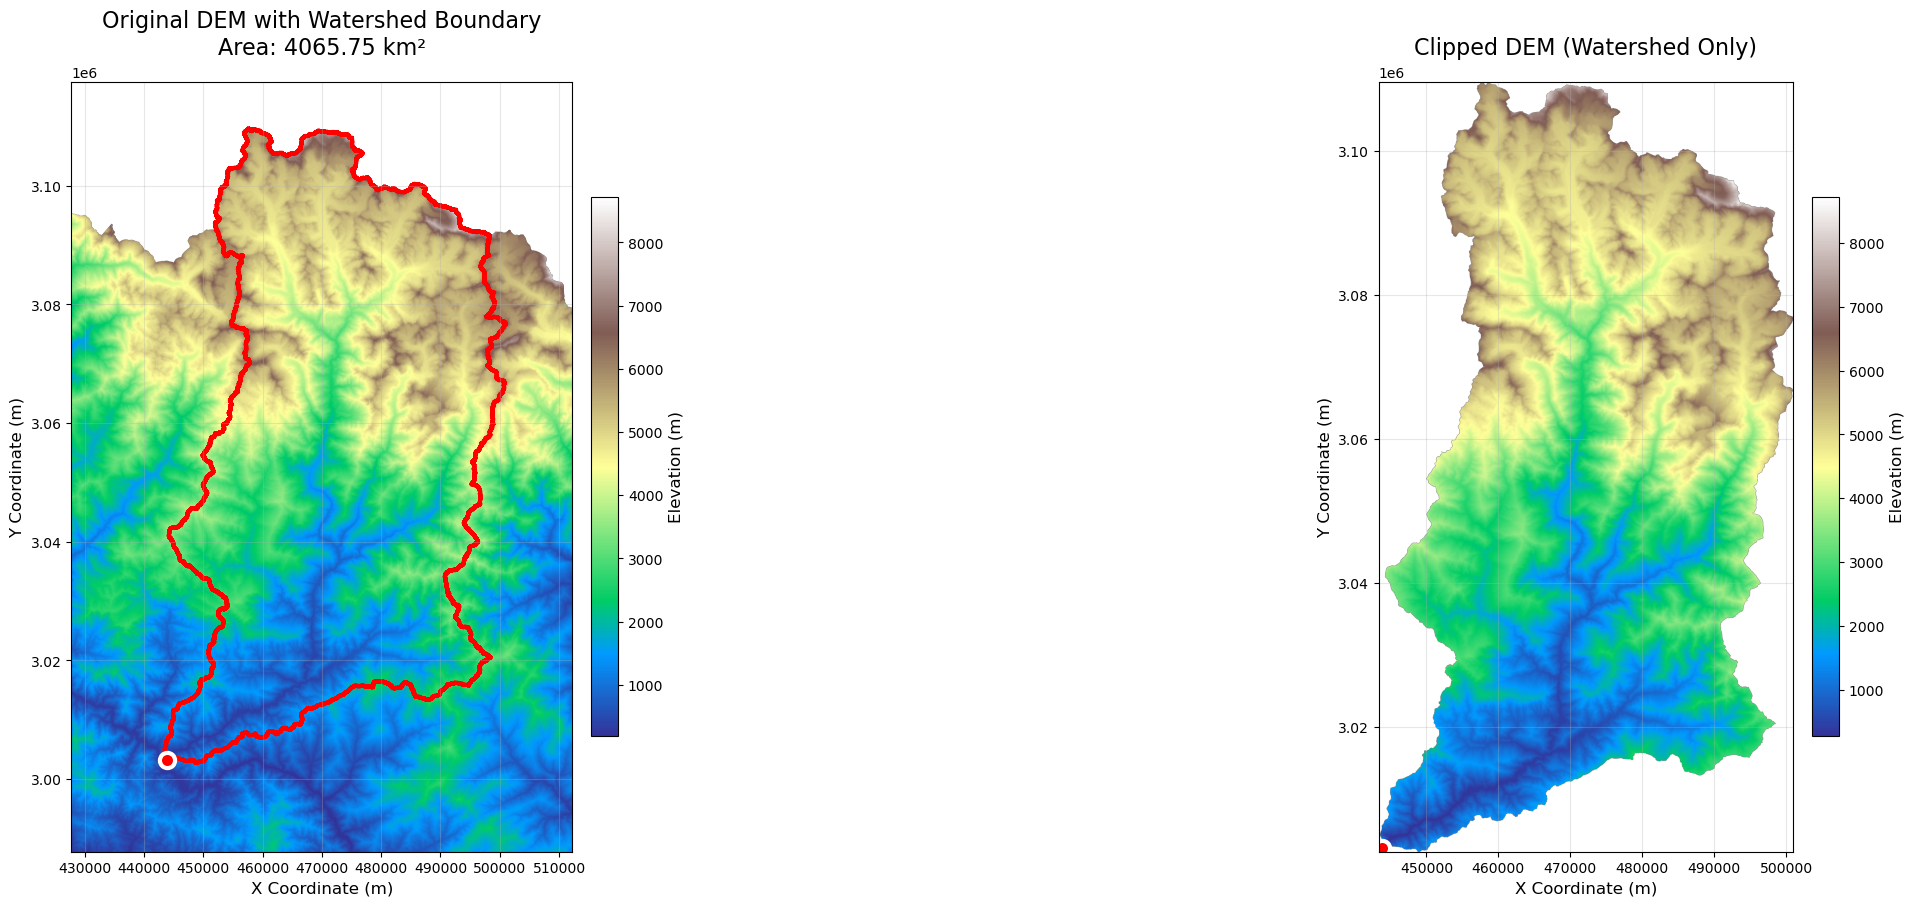

Results saved to: results
Watershed delineation completed!
Processing geospatial tools with watershed DEM
Running QGIS slope...
 QGIS slope completed
Running SAGA slope...
 SAGA slope completed
Running GRASS slope...
 GRASS slope completed
Running OTB edge detection...
 OTB edge detection completed
Running OTB band math...
 OTB band math completed
Running WhiteboxTools slope...
 WhiteboxTools slope completed
Running GDAL hillshade...
 GDAL hillshade completed

Processing completed - generating visualization
QGIS - Slope: min=0.000, max=87.632, mean=31.970
SAGA - Slope: min=0.000, max=87.645, mean=32.099
GRASS - Slope: min=0.000, max=87.632, mean=31.983
OTB - Edges: min=0.000, max=2933.220, mean=2.993
WhiteboxTools - Slope: min=0.000, max=87.958, mean=32.160
GDAL - Hillshade: min=1.000, max=255.000, mean=146.073


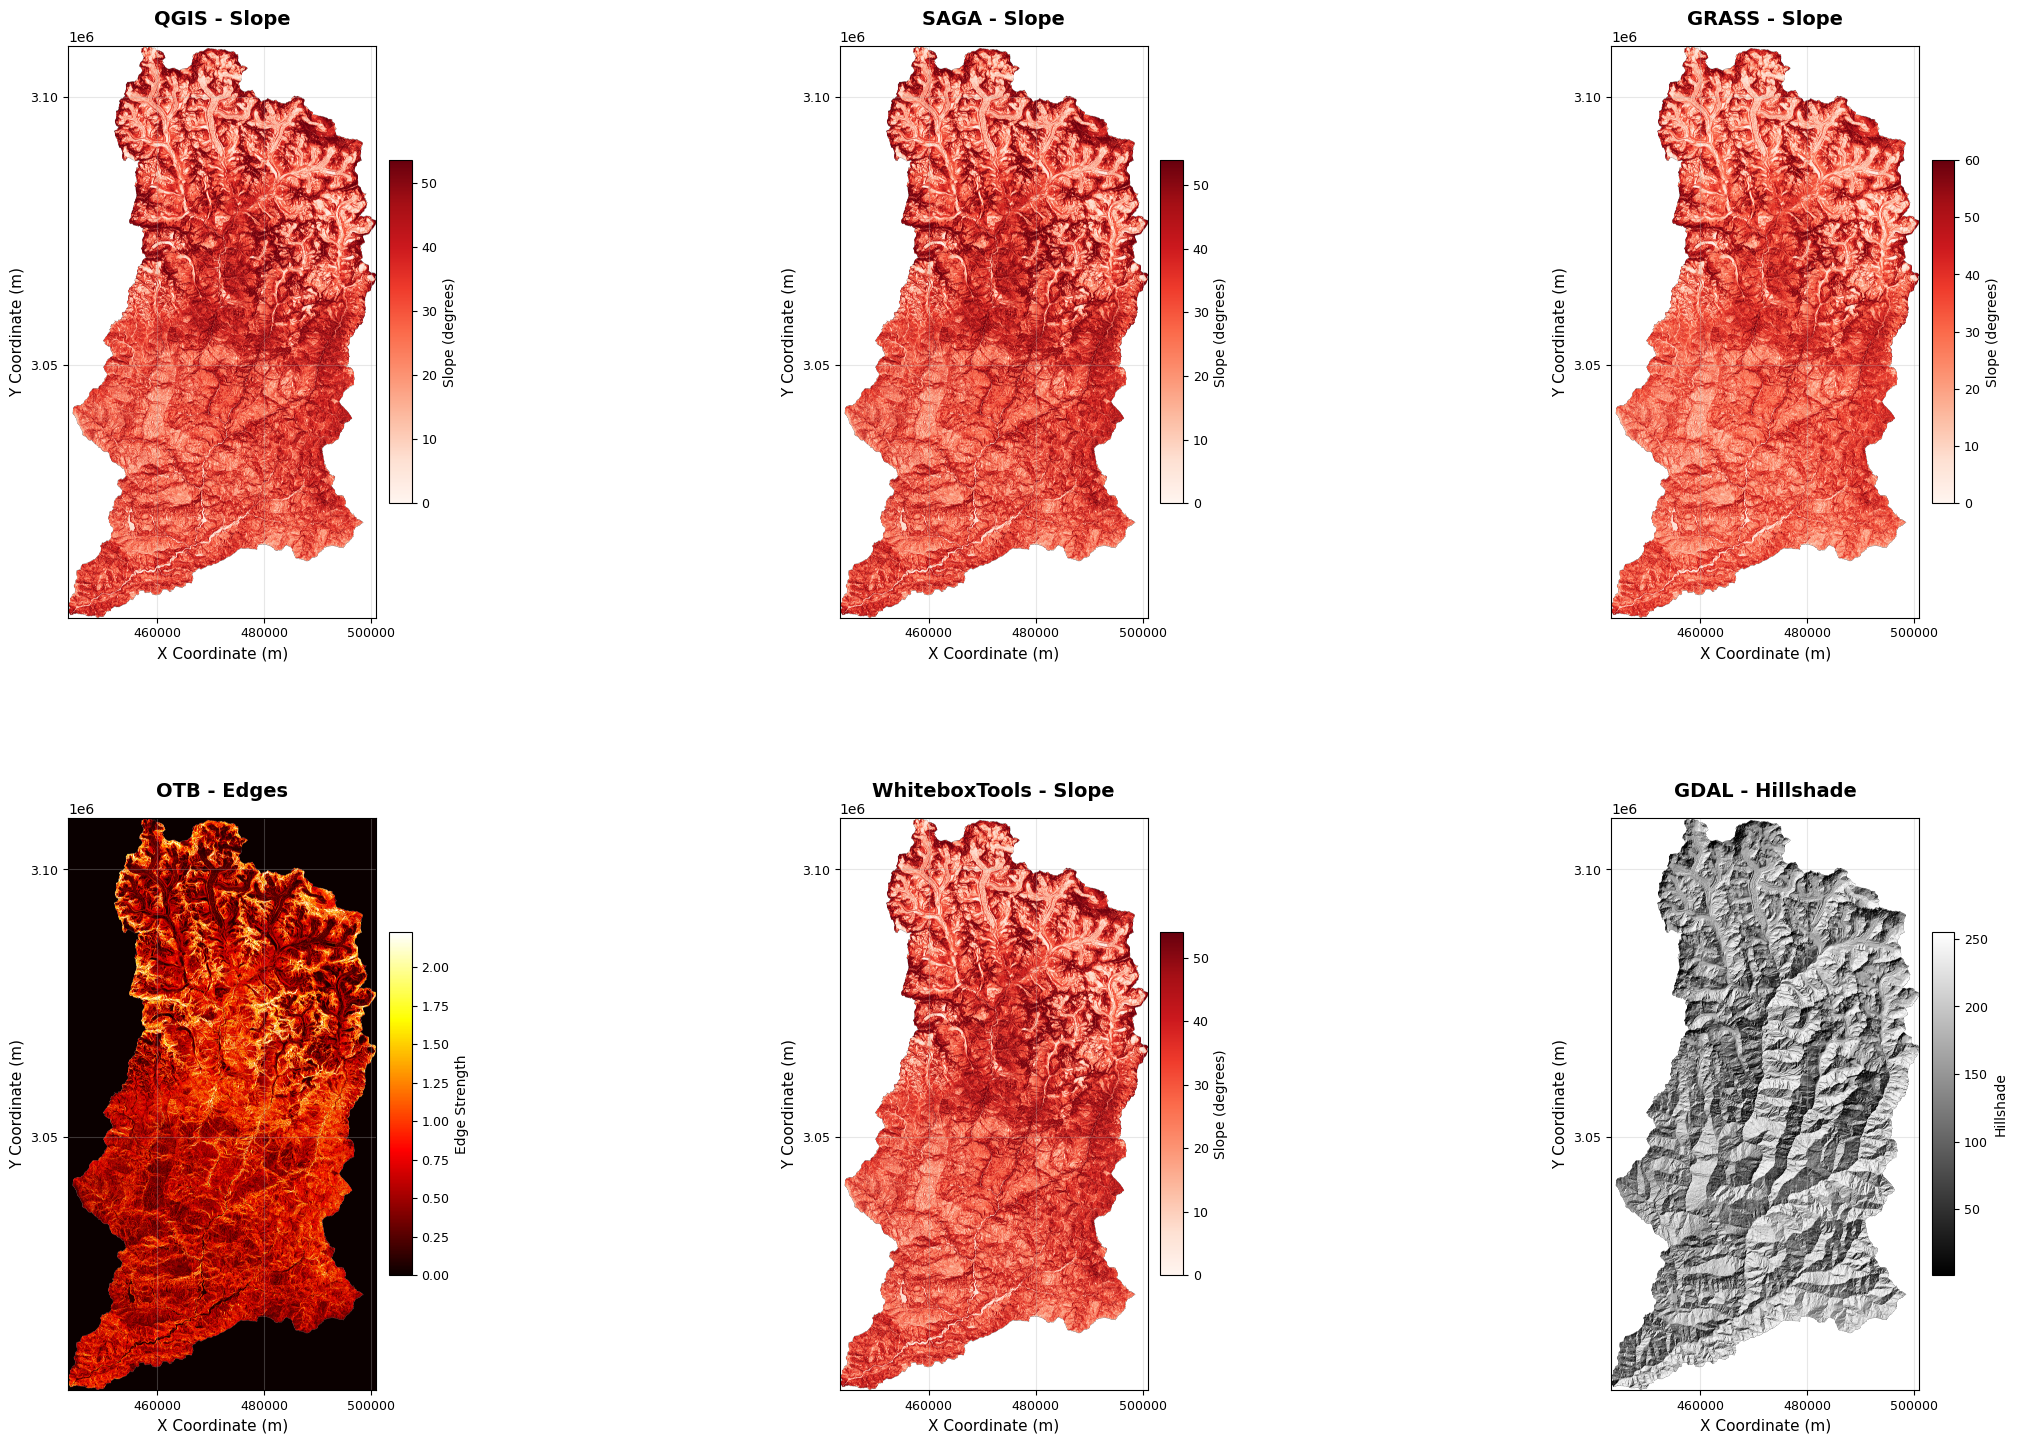

All geospatial tools completed successfully


 QGIS slope completed
Running SAGA slope...
 SAGA slope failed: Command '['/opt/saga/bin/saga_cmd', 'ta_morphometry', '0', '-ELEVATION=results/clipped_dem.tif', '-SLOPE=saga_slope.tif', '-METHOD=6', '-UNIT=1']' returned non-zero exit status 1.
Running GRASS slope...
 GRASS slope completed
Running OTB edge detection...
 OTB edge detection completed
Running OTB band math...
 OTB band math completed
Running WhiteboxTools slope...
 WhiteboxTools slope completed
Running GDAL hillshade...
 GDAL hillshade completed

Processing completed - generating visualization
QGIS - Slope: min=0.000, max=87.632, mean=31.970
SAGA - Slope: min=0.000, max=1.530, mean=0.560
GRASS - Slope: min=0.000, max=87.632, mean=31.983
OTB - Edges: min=0.000, max=2933.220, mean=2.992
WhiteboxTools - Slope: min=0.000, max=87.958, mean=32.160
GDAL - Hillshade: min=1.000, max=255.000, mean=146.073


In [10]:
# watershed_analysis.py

import json
import os
import numpy as np
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import folium
from folium.plugins import MousePosition
from pyproj import Transformer
import warnings
warnings.filterwarnings('ignore')

# Create JSON configuration file if it doesn't exist
if not os.path.exists("watershed_analysis.json"):
    config_data = {
      "dem_path": "/workspace/Road_Induced_Solu/Solu_Dem/Solu.tif",
      "temp_dir": "temp_watershed",
      "output_dir": "results",
      "watershed_dem": "results/clipped_dem.tif",
      "coordinate_systems": {
        "wgs84": "EPSG:4326"
      },
      "conda_env_path": "/opt/conda/envs/pygile",
      "saga_cmd": "/opt/saga/bin/saga_cmd",
      "saga_lib": "/opt/saga/lib/saga",
      "grass_bin": "/opt/grass/grass84/bin",
      "otb_bin": "/opt/otb/bin",
      "whitebox_tools": "/opt/conda/envs/pygile/bin/whitebox_tools"
    }
    
    with open("watershed_analysis.json", "w") as f:
        json.dump(config_data, f, indent=2)

# Load configuration from JSON file
with open("watershed_analysis.json", "r") as f:
    config = json.load(f)

dem_path = config["dem_path"]
temp_dir = config["temp_dir"]
output_dir = config["output_dir"]
watershed_dem = config["watershed_dem"]

class WatershedDelineator:
    def __init__(self, dem_path):
        self.dem_path = dem_path
        self.temp_dir = temp_dir
        os.makedirs(self.temp_dir, exist_ok=True)
        
        # Load DEM metadata
        with rasterio.open(dem_path) as src:
            self.cell_size = src.res[0]
            self.crs = src.crs
            bounds = src.bounds
            
            # Coordinate transformers
            wgs84_crs = config["coordinate_systems"]["wgs84"]
            self.to_wgs84 = Transformer.from_crs(self.crs, wgs84_crs, always_xy=True)
            self.from_wgs84 = Transformer.from_crs(wgs84_crs, self.crs, always_xy=True)
            
            # DEM bounds in WGS84
            minx, miny = self.to_wgs84.transform(bounds.left, bounds.bottom)
            maxx, maxy = self.to_wgs84.transform(bounds.right, bounds.top)
            self.bounds_wgs84 = {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
    
    def get_pour_point(self):
        # Create interactive map
        center_lat = (self.bounds_wgs84['miny'] + self.bounds_wgs84['maxy']) / 2
        center_lng = (self.bounds_wgs84['minx'] + self.bounds_wgs84['maxx']) / 2
        
        m = folium.Map(location=[center_lat, center_lng], zoom_start=12)
        
        # Add satellite layer
        folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri', name='Satellite'
        ).add_to(m)
        
        # DEM boundary
        bounds_coords = [
            [self.bounds_wgs84['miny'], self.bounds_wgs84['minx']],
            [self.bounds_wgs84['miny'], self.bounds_wgs84['maxx']],
            [self.bounds_wgs84['maxy'], self.bounds_wgs84['maxx']],
            [self.bounds_wgs84['maxy'], self.bounds_wgs84['minx']]
        ]
        folium.Polygon(bounds_coords, color='red', weight=3, fill=True, fillOpacity=0.1).add_to(m)
        
        MousePosition().add_to(m)
        folium.LatLngPopup().add_to(m)
        folium.LayerControl().add_to(m)
        
        # Display map
        try:
            from IPython.display import display
            display(m)
        except ImportError:
            m.save("pour_point_map.html")
            print("Map saved to: pour_point_map.html")
        
        print(f"Click within red rectangle. Bounds: Lat {self.bounds_wgs84['miny']:.6f} to {self.bounds_wgs84['maxy']:.6f}, Lng {self.bounds_wgs84['minx']:.6f} to {self.bounds_wgs84['maxx']:.6f}")
        
        # Get coordinates
        while True:
            try:
                lat = float(input("Latitude: ").strip())
                lng = float(input("Longitude: ").strip())
                
                if (self.bounds_wgs84['miny'] <= lat <= self.bounds_wgs84['maxy'] and 
                    self.bounds_wgs84['minx'] <= lng <= self.bounds_wgs84['maxx']):
                    if input(f"Use Lat={lat:.6f}, Lng={lng:.6f}? (y/n): ").lower() == 'y':
                        return lat, lng
                else:
                    print("Coordinates outside DEM bounds!")
            except ValueError:
                print("Invalid format!")
    
    def delineate_watershed(self, lat, lng):
        try:
            import whitebox
        except ImportError:
            print("Install WhiteboxTools: pip install whitebox")
            return None, None
        
        # Transform coordinates
        x_proj, y_proj = self.from_wgs84.transform(lng, lat)
        
        # Create pour point shapefile
        gdf = gpd.GeoDataFrame({'id': [1]}, geometry=gpd.points_from_xy([x_proj], [y_proj]), crs=self.crs)
        pour_point_path = os.path.join(self.temp_dir, 'pour_point.shp')
        gdf.to_file(pour_point_path)
        
        # WhiteboxTools processing
        wbt = whitebox.WhiteboxTools()
        wbt.set_verbose_mode(False)
        wbt.set_working_dir(os.path.abspath(self.temp_dir))
        
        # Copy DEM
        import shutil
        shutil.copy2(self.dem_path, os.path.join(self.temp_dir, 'dem.tif'))
        
        # Watershed processing
        wbt.fill_depressions('dem.tif', 'dem_filled.tif')
        wbt.d8_pointer('dem_filled.tif', 'd8_pointer.tif')
        wbt.d8_flow_accumulation('d8_pointer.tif', 'flow_accum.tif', pntr=True)
        
        threshold = max(500, int(500000 / (self.cell_size * self.cell_size)))
        wbt.extract_streams('flow_accum.tif', 'streams.tif', threshold)
        
        snap_distance = self.cell_size * 20
        wbt.jenson_snap_pour_points('pour_point.shp', 'streams.tif', 'pour_point_snapped.shp', snap_distance)
        wbt.watershed('d8_pointer.tif', 'pour_point_snapped.shp', 'watershed.tif')
        
        # Convert to vector
        watershed_vector = self._raster_to_vector()
        
        # Clip DEM with watershed
        clipped_dem = self._clip_dem_with_watershed(watershed_vector)
        
        return watershed_vector, clipped_dem
    
    def _raster_to_vector(self):
        watershed_raster = os.path.join(self.temp_dir, 'watershed.tif')
        
        try:
            from rasterio.features import shapes
            
            with rasterio.open(watershed_raster) as src:
                data = src.read(1)
                transform = src.transform
                crs = src.crs
            
            polygons = []
            for geom, value in shapes(data.astype(np.int32), mask=data > 0, transform=transform):
                if value > 0:
                    polygons.append(shape(geom))
            
            if polygons:
                gdf = gpd.GeoDataFrame({'watershed_id': range(len(polygons))}, geometry=polygons)
                gdf.set_crs(crs, inplace=True)
                
                vector_path = os.path.join(self.temp_dir, 'watershed_vector.shp')
                gdf.to_file(vector_path)
                return vector_path
                
        except Exception as e:
            print(f"Error converting to vector: {e}")
            return None
    
    def _clip_dem_with_watershed(self, watershed_vector):
        if not watershed_vector:
            return None
            
        try:
            # Read watershed polygon
            watershed_gdf = gpd.read_file(watershed_vector)
            
            # Clip DEM with watershed boundary
            with rasterio.open(self.dem_path) as src:
                out_image, out_transform = rasterio.mask.mask(src, watershed_gdf.geometry, crop=True)
                out_meta = src.meta.copy()
                
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                clipped_dem_path = os.path.join(self.temp_dir, 'clipped_dem.tif')
                with rasterio.open(clipped_dem_path, "w", **out_meta) as dest:
                    dest.write(out_image)
                
                return clipped_dem_path
                
        except Exception as e:
            print(f"Error clipping DEM: {e}")
            return None
    
    def visualize_results(self, watershed_vector, clipped_dem, lat, lng, output_dir="results"):
        os.makedirs(output_dir, exist_ok=True)
        
        if not watershed_vector or not clipped_dem:
            print("Missing results for visualization")
            return
        
        x_proj, y_proj = self.from_wgs84.transform(lng, lat)
        
        # Read data
        with rasterio.open(self.dem_path) as src:
            original_dem = src.read(1, masked=True)
            original_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        with rasterio.open(clipped_dem) as src:
            clipped_data = src.read(1, masked=True)
            clipped_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        watershed_gdf = gpd.read_file(watershed_vector)
        area_km2 = watershed_gdf.geometry.area.sum() / 1e6
        
        # Create visualization with spaced subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # Add more spacing
        
        # Original DEM with watershed boundary
        im1 = ax1.imshow(original_dem, extent=original_extent, cmap='terrain', aspect='equal')
        watershed_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=3)
        ax1.scatter(x_proj, y_proj, c='red', s=120, marker='o', edgecolor='white', linewidth=3)
        ax1.set_title(f'Original DEM with Watershed Boundary\nArea: {area_km2:.2f} km²', fontsize=16, pad=20)
        ax1.set_xlabel('X Coordinate (m)', fontsize=12)
        ax1.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Position colorbar with more space
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.7, aspect=20, pad=0.02)
        cbar1.set_label('Elevation (m)', fontsize=12)
        
        # Clipped DEM
        im2 = ax2.imshow(clipped_data, extent=clipped_extent, cmap='terrain', aspect='equal')
        ax2.scatter(x_proj, y_proj, c='red', s=120, marker='o', edgecolor='white', linewidth=3)
        ax2.set_title('Clipped DEM (Watershed Only)', fontsize=16, pad=20)
        ax2.set_xlabel('X Coordinate (m)', fontsize=12)
        ax2.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7, aspect=20, pad=0.02)
        cbar2.set_label('Elevation (m)', fontsize=12)
        
        # Save
        viz_path = os.path.join(output_dir, 'watershed_results.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Copy results to output directory
        import shutil
        shutil.copy2(watershed_vector, os.path.join(output_dir, 'watershed.shp'))
        shutil.copy2(clipped_dem, os.path.join(output_dir, 'clipped_dem.tif'))
        
        print(f"Results saved to: {output_dir}")
        return viz_path

# QGIS
def qgis_slope(input_dem, output_slope):
    if not os.path.exists(input_dem):
        raise FileNotFoundError(f"Input DEM not found: {input_dem}")
    
    conda_env = os.environ.copy()
    conda_env['QT_QPA_PLATFORM'] = 'offscreen'
    conda_env['QGIS_PREFIX_PATH'] = config["conda_env_path"]
    conda_env['LD_LIBRARY_PATH'] = f'{config["conda_env_path"]}/lib'
    
    qgis_script = f"""
import sys
sys.path.insert(0, '{config["conda_env_path"]}/share/qgis/python')
from qgis.core import QgsApplication
QgsApplication.setPrefixPath('{config["conda_env_path"]}', True)
app = QgsApplication([], False)
app.initQgis()
import processing
from processing.core.Processing import Processing
Processing.initialize()
processing.run("native:slope", {{'INPUT': '{input_dem}', 'Z_FACTOR': 1, 'OUTPUT': '{output_slope}'}})
app.exitQgis()
"""
    
    import subprocess
    subprocess.run([f'{config["conda_env_path"]}/bin/python', '-c', qgis_script], 
                   env=conda_env, check=True)

# SAGA - Using your exact logic with correct parameters
def saga_slope(input_dem, output_slope):
    """Extract SAGA algorithms using your exact technique"""
    import re
    import subprocess
    
    env = {
        'LD_LIBRARY_PATH': '/opt/saga/lib:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/opt/conda/envs/pygile/lib',
        'SAGA_MLB': '/opt/saga/lib/saga'
    }
    
    # Get libraries
    result = subprocess.run(["/opt/saga/bin/saga_cmd"], capture_output=True, text=True, env=env)
    
    libraries = []
    for line in result.stdout.split('\n'):
        if line.startswith(' - '):
            lib_name = line[3:].strip().rstrip(' *')
            if lib_name and not lib_name.startswith('_'):
                libraries.append(lib_name)
    
    unique_libraries = list(dict.fromkeys(libraries))
    
    algorithms_data = []
    
    for lib in unique_libraries:
        result = subprocess.run(["/opt/saga/bin/saga_cmd", lib], capture_output=True, text=True, env=env)
        
        for line in result.stdout.split('\n'):
            match = re.match(r'^\s*\[(\d+)\]\s+(.+)', line)
            if match:
                tool_id = match.group(1)
                tool_name = match.group(2).strip()
                algorithms_data.append([lib, tool_id, tool_name])
    
    # Find slope algorithm and execute with required ASPECT parameter
    for lib, tool_id, tool_name in algorithms_data:
        if 'slope' in tool_name.lower() and 'morphometry' in lib.lower():
            try:
                # Create temporary aspect file name
                aspect_temp = output_slope.replace('.tif', '_aspect_temp.tif')
                subprocess.run(["/opt/saga/bin/saga_cmd", lib, tool_id, 
                              f"-ELEVATION={input_dem}", f"-SLOPE={output_slope}", f"-ASPECT={aspect_temp}", "-UNIT_SLOPE=1"], 
                             env=env, check=True, capture_output=True, text=True)
                # Clean up temporary aspect file
                import os
                if os.path.exists(aspect_temp):
                    os.remove(aspect_temp)
                return
            except:
                continue
    
    raise Exception("SAGA slope not found")
    
# GRASS
def grass_slope(input_dem, output_slope):
    import tempfile
    import shutil
    
    temp_dir = tempfile.mkdtemp()
    gisdbase = os.path.join(temp_dir, "grassdb")
    location = "temp_location"
    mapset = "PERMANENT"
    permanent_dir = os.path.join(gisdbase, location, mapset)
    
    os.makedirs(permanent_dir)
    
    gisrc = os.path.join(temp_dir, "gisrc")
    with open(gisrc, 'w') as f:
        f.write(f"GISDBASE: {gisdbase}\nLOCATION_NAME: {location}\nMAPSET: {mapset}\n")
    
    # Create proper WIND files
    with open(os.path.join(permanent_dir, "DEFAULT_WIND"), 'w') as f:
        f.write("proj: 0\nzone: 0\nnorth: 1\nsouth: 0\neast: 1\nwest: 0\n")
        f.write("cols: 1\nrows: 1\ne-w resol: 1\nn-s resol: 1\ntop: 1\nbottom: 0\n")
    
    shutil.copy2(os.path.join(permanent_dir, "DEFAULT_WIND"), 
                 os.path.join(permanent_dir, "WIND"))
    
    grass_env = os.environ.copy()
    grass_env['GISRC'] = gisrc
    grass_env['GISBASE'] = config["grass_bin"][:-4]
    grass_env['PATH'] = f'{config["grass_bin"]}:{config["grass_bin"]}:/usr/local/bin:/usr/bin:/bin'
    grass_env['LD_LIBRARY_PATH'] = f'{config["grass_bin"][:-4]}/lib'
    grass_env['GDAL_DATA'] = '/usr/share/gdal'
    grass_env['PROJ_LIB'] = '/usr/share/proj'
    grass_env['GDAL_DRIVER_PATH'] = 'disable'
    grass_env['LC_ALL'] = 'C'
    
    try:
        import subprocess
        subprocess.run([f'{config["grass_bin"]}/r.in.gdal', 
                       f'input={input_dem}', 'output=dem', '--overwrite', '-o'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/g.region', 'raster=dem'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/r.slope.aspect', 
                       'elevation=dem', 'slope=slope_out', 'format=degrees', '--overwrite'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/r.out.gdal', 
                       'input=slope_out', f'output={output_slope}', '--overwrite'], 
                      env=grass_env, check=True, capture_output=True)
    finally:
        shutil.rmtree(temp_dir)

# OTB
def otb_edge_detection(input_dem, output_edges):
    otb_env = os.environ.copy()
    otb_env['PATH'] = f'{config["otb_bin"]}:/usr/local/bin:/usr/bin:/bin'
    otb_env['LD_LIBRARY_PATH'] = f'{config["otb_bin"][:-4]}/lib'
    otb_env['OTB_APPLICATION_PATH'] = f'{config["otb_bin"][:-4]}/lib/otb/applications'
    otb_env['GDAL_DATA'] = f'{config["otb_bin"][:-4]}/share/gdal'
    
    import subprocess
    try:
        subprocess.run([
            f'{config["otb_bin"]}/otbcli_EdgeExtraction',
            '-in', input_dem, 
            '-channel', '1',
            '-filter', 'sobel', 
            '-filter.sobel.xradius', '2', 
            '-filter.sobel.yradius', '2', 
            '-out', output_edges, 'float'
        ], env=otb_env, check=True, capture_output=True)
    except:
        try:
            subprocess.run([
                f'{config["otb_bin"]}/otbcli_EdgeExtraction',
                '-in', input_dem, 
                '-channel', '1',
                '-filter', 'gradient',
                '-out', output_edges, 'float'
            ], env=otb_env, check=True, capture_output=True)
        except:
            subprocess.run([
                f'{config["otb_bin"]}/otbcli_BandMath',
                '-il', input_dem,
                '-exp', 'sqrt((im1b1-im1b1[1,0])^2 + (im1b1-im1b1[0,1])^2)',
                '-out', output_edges, 'float'
            ], env=otb_env, check=True, capture_output=True)

def otb_band_math(input_dem, output_result, expression="im1b1*2"):
    otb_env = os.environ.copy()
    otb_env['PATH'] = f'{config["otb_bin"]}:/usr/local/bin:/usr/bin:/bin'
    otb_env['LD_LIBRARY_PATH'] = f'{config["otb_bin"][:-4]}/lib'
    otb_env['OTB_APPLICATION_PATH'] = f'{config["otb_bin"][:-4]}/lib/otb/applications'
    otb_env['GDAL_DATA'] = f'{config["otb_bin"][:-4]}/share/gdal'
    
    import subprocess
    subprocess.run([
        f'{config["otb_bin"]}/otbcli_BandMath',
        '-il', input_dem, '-exp', expression, '-out', output_result
    ], env=otb_env, check=True, capture_output=True)

# WhiteboxTools
def whitebox_slope(input_dem, output_slope):
    import subprocess
    subprocess.run([
        config["whitebox_tools"],
        '--run=Slope', f'--dem={input_dem}', f'--output={output_slope}',
        '--units=degrees', '--verbose=false'
    ], check=True, capture_output=True)

# GDAL
def gdal_hillshade(input_dem, output_hillshade):
    gdal_env = os.environ.copy()
    gdal_env['PATH'] = f'{config["conda_env_path"]}/bin:/usr/local/bin:/usr/bin:/bin'
    gdal_env['LD_LIBRARY_PATH'] = f'{config["conda_env_path"]}/lib'
    
    import subprocess
    subprocess.run([
        f'{config["conda_env_path"]}/bin/gdaldem', 'hillshade',
        input_dem, output_hillshade
    ], env=gdal_env, check=True, capture_output=True)

# Visualization with better spacing
def visualize_slopes():
    import matplotlib.pyplot as plt
    import rasterio
    import numpy as np
    import gc
    
    slope_files = [
        ("qgis_slope.tif", "QGIS - Slope", "Reds"),
        ("saga_slope.tif", "SAGA - Slope", "Reds"), 
        ("grass_slope.tif", "GRASS - Slope", "Reds"),
        ("otb_edges.tif", "OTB - Edges", "hot"),
        ("wb_slope.tif", "WhiteboxTools - Slope", "Reds"),
        ("hillshade.tif", "GDAL - Hillshade", "gray")
    ]
    
    existing_files = [(f, t, c) for f, t, c in slope_files if os.path.exists(f)]
    
    if not existing_files:
        print("No output files found to visualize")
        return
    
    # Determine layout based on number of files
    n_files = len(existing_files)
    if n_files <= 3:
        rows, cols = 1, n_files
        figsize = (8*n_files, 6)
    elif n_files <= 6:
        rows, cols = 2, 3
        figsize = (24, 16)
    else:
        rows, cols = 3, 3
        figsize = (24, 24)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08, wspace=0.25, hspace=0.35)  # Better spacing
    
    # Handle single subplot case
    if n_files == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for i, (filename, title, cmap) in enumerate(existing_files):
        try:
            with rasterio.open(filename) as src:
                data = src.read(1, masked=True)
                extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
                
                print(f"{title}: min={np.nanmin(data):.3f}, max={np.nanmax(data):.3f}, mean={np.nanmean(data):.3f}")
                
                if "slope" in title.lower():
                    if "grass" in title.lower():
                        data = np.abs(data)
                    
                    vmin, vmax = 0, min(60, np.nanpercentile(data, 95))
                    im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
                elif "edge" in title.lower():
                    if np.nanmax(data) > np.nanmin(data):
                        vmin, vmax = np.nanpercentile(data, [1, 99])
                        im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
                    else:
                        im = axes[i].imshow(np.zeros_like(data), cmap=cmap, extent=extent, aspect='equal')
                        axes[i].text(0.5, 0.5, 'No edges detected\n(flat terrain)', 
                                   ha='center', va='center', transform=axes[i].transAxes,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
                else:
                    im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal')
                
                axes[i].set_title(title, fontsize=14, fontweight='bold', pad=15)
                axes[i].set_xlabel('X Coordinate (m)', fontsize=11)
                axes[i].set_ylabel('Y Coordinate (m)', fontsize=11)
                
                axes[i].locator_params(axis='both', nbins=4)
                axes[i].tick_params(axis='both', which='major', labelsize=9)
                axes[i].grid(True, alpha=0.3)
                
                cbar = plt.colorbar(im, ax=axes[i], shrink=0.6, aspect=15, pad=0.02)
                if "slope" in title.lower():
                    cbar.set_label('Slope (degrees)', fontsize=10)
                elif "hillshade" in title.lower():
                    cbar.set_label('Hillshade', fontsize=10)
                elif "edge" in title.lower():
                    cbar.set_label('Edge Strength', fontsize=10)
                cbar.ax.tick_params(labelsize=9)
                
                del data
                gc.collect()
                
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{filename}\n{str(e)[:50]}...", 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
            axes[i].set_title(title, fontsize=14, fontweight='bold')
            axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.savefig('geospatial_analysis_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    gc.collect()

# Main execution
def run_watershed_delineation(dem_path, output_dir="results"):
    delineator = WatershedDelineator(dem_path)
    
    # Get pour point
    lat, lng = delineator.get_pour_point()
    
    # Delineate watershed and clip DEM
    watershed_vector, clipped_dem = delineator.delineate_watershed(lat, lng)
    
    if watershed_vector and clipped_dem:
        # Visualize and save results
        delineator.visualize_results(watershed_vector, clipped_dem, lat, lng, output_dir)
        print("Watershed delineation completed!")
        return watershed_vector, clipped_dem
    else:
        print("Watershed delineation failed!")
        return None, None

def main():
    if not os.path.exists(dem_path):
        print(f"DEM file not found: {dem_path}")
        return
    
    # Watershed delineation
    watershed_vector, clipped_dem = run_watershed_delineation(dem_path, output_dir)
    
    if watershed_vector and clipped_dem:
        watershed_dem = config["watershed_dem"]
        
        if os.path.exists(watershed_dem):
            print("Processing geospatial tools with watershed DEM")
            
            try:
                print("Running QGIS slope...")
                qgis_slope(watershed_dem, "qgis_slope.tif")
                print(" QGIS slope completed")
            except Exception as e:
                print(f" QGIS slope failed: {e}")
            
            try:
                print("Running SAGA slope...")
                saga_slope(watershed_dem, "saga_slope.tif")
                print(" SAGA slope completed")
            except Exception as e:
                print(f" SAGA slope failed: {e}")
            
            try:
                print("Running GRASS slope...")
                grass_slope(watershed_dem, "grass_slope.tif")
                print(" GRASS slope completed")
            except Exception as e:
                print(f" GRASS slope failed: {e}")
            
            try:
                print("Running OTB edge detection...")
                otb_edge_detection(watershed_dem, "otb_edges.tif")
                print(" OTB edge detection completed")
            except Exception as e:
                print(f" OTB edge detection failed: {e}")
            
            try:
                print("Running OTB band math...")
                otb_band_math(watershed_dem, "otb_doubled.tif", "im1b1*2")
                print(" OTB band math completed")
            except Exception as e:
                print(f" OTB band math failed: {e}")
            
            try:
                print("Running WhiteboxTools slope...")
                whitebox_slope(watershed_dem, "wb_slope.tif")
                print(" WhiteboxTools slope completed")
            except Exception as e:
                print(f" WhiteboxTools slope failed: {e}")
            
            try:
                print("Running GDAL hillshade...")
                gdal_hillshade(watershed_dem, "hillshade.tif")
                print(" GDAL hillshade completed")
            except Exception as e:
                print(f" GDAL hillshade failed: {e}")
            
            print("\nProcessing completed - generating visualization")
            visualize_slopes()
            print("All geospatial tools completed successfully")

if __name__ == "__main__":
    main()